Goal:
- Select features via Random Forest and LaSSO and compare the results

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
import datetime
import pickle
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

import statsmodels.formula.api as smf  

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
def feat_sel(df, output, model='rf', alpha=100, feat_num=20):
    '''
    performs random forest or lasso fit on specified dataframe and produces a list of 
    the top specified number of features and returns a sorted list of the features and their scores.
    '''
    regressors = list(set(df.columns) - set([output]))

    y = df[output]
    X = df[regressors] #select all the columns after id and geography -- the regressors
    names = X.columns

    rlasso = RandomizedLasso(alpha=alpha,random_state=0, normalize=True, fit_intercept=True)
    rlasso.fit(X, y)

    rf = RandomForestRegressor(random_state=0,n_estimators=100)
    rf.fit(X, y)

    if model == 'lasso':
        feat_sort = (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))
    else: 
        feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
        print ('R-Score', rf.score(X, y))

    pl.figure(figsize=(8,6))
    pl.title("{} Feature importance".format(model))
    pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
    pl.xticks(np.arange(feat_num))
    pl.ylabel('Importance Score')

    print("{} Feature ranking:".format(model), pd.DataFrame(feat_sort)[:5])
    return feat_sort

In [17]:
def mdl_eval(mdl, output, regressors, test, train, color):
    ''' For a specific model, produce the in sample R square value, the out of sample r sqaure, 
        and the median absolute error. Returns the '''
    
    print ('In Sample RSquared: ', mdl.score(train[regressors], train[output]))
    Rout = r2_score(test[output], mdl.predict(test[regressors]))
    R = Rout
    p = len(regressors)
    n = len(test)
    Radj = R - ((1 - R)*((p)/(n-p-1)))
    print ('Out of sample R-Squared: ', Rout)
    print ('Out of sample Adjusted R-Squared: ', Radj)
    model_score = median_absolute_error(test[output], mdl.predict(test[regressors]))
    print ('Model Eval (Median Absolute Error): ', model_score)
    
    pl.figure(figsize=(8,6))
    pl.title("Radj = {}, p = {}".format(Radj, p), fontsize=16)
    pl.plot(test[output], mdl.predict(test[regressors]), 'o', alpha=.5, c=color)
    pl.plot(test[output], test[output])
    pl.xlabel('Observed Values', fontsize=14)
    pl.ylabel('Predicted Values', fontsize=14)
    
    return (Radj, model_score)

In [3]:
path = './data/consolidatedClean.csv'
data = pd.read_csv(path)
data.head()

,Unnamed: 0,zip,tc_2 # OF PROPERTIES,tc_2 FY'2017 MARKET VALUE LAND,tc_2 FY'2017 MARKET VALUE TOTAL,tc_2 FY'2017 ASSESSED VALUE LAND,tc_2 FY'2017 ASSESSED VALUE TOTAL,tc_2 FY'2017 EXEMPT VALUE LAND,tc_2 FY'2017 EXEMPT VALUE TOTAL,tc_2 FY'2017 ACTUAL ASSESSED VALUE LAND,...,listing,listingsHouseholdsRatio,listings_per_sqmi,note,park_area,sq_mi_area,stop_density,tree_count,tree_density,zip_area
0,0,10001,1471,780125048,4538886185,290671105,1658138801,81524077,686730527,320717141,...,126,0.010826,202.783689,NaN,0.005287,0.621352,0.000004,911.000,1466.158257,0.621352
1,1,10002,2480,1119441624,4725893887,433821548,1705825116,194114612,763757475,449310179,...,217,0.006507,246.770728,NaN,0.158087,0.879359,0.000002,2265.000,2575.740552,0.879359
2,2,10003,3735,1598012608,8310198962,521608957,2700093121,33872345,198475327,537001788,...,190,0.006912,329.625393,NaN,0.037266,0.576412,0.000005,2025.000,3513.112743,0.576412
3,3,10004,833,86698487,644247080,33694636,239754510,326200,48617039,33694659,...,3,0.001906,5.360108,NaN,0.115819,0.559690,0.000002,118.000,210.830927,0.559690
4,4,10005,1650,371514875,1650726876,166694449,648149892,4251656,143404591,166694449,...,21,0.004939,285.658117,NaN,0.172902,0.073514,0.000002,3736.816,2842.071016,1.449180


In [4]:
data.drop(['Unnamed: 0',  'Unnamed: 0.1'], axis=1, inplace=True)

In [5]:
for i in data.columns:
    nulls = data[i].isnull().sum()
    if nulls > 0:
        print (i, data[i].isnull().sum(), '\n\n')

GEO.display-label 61 


GEO.id 61 


NAICS.display-label 61 


RCPSZFE.display-label 61 


note 171 




In [6]:
data.columns

Index(['zip', 'tc_2 # OF PROPERTIES', 'tc_2  FY'2017 MARKET VALUE LAND',
       'tc_2  FY'2017 MARKET VALUE TOTAL', 'tc_2  FY'2017 ASSESSED VALUE LAND',
       'tc_2  FY'2017 ASSESSED VALUE TOTAL', 'tc_2  FY'2017 EXEMPT VALUE LAND',
       'tc_2  FY'2017 EXEMPT VALUE TOTAL',
       'tc_2  FY'2017 ACTUAL ASSESSED VALUE LAND',
       'tc_2  FY'2017 ACTUAL ASSESSED VALUE TOTAL',
       ...
       'listing', 'listingsHouseholdsRatio', 'listings_per_sqmi', 'note',
       'park_area', 'sq_mi_area', 'stop_density', 'tree_count', 'tree_density',
       'zip_area'],
      dtype='object', length=590)

In [7]:
data.drop(['bcode','note','boro','listings_per_sqmi',
           'listing','geometry','Id','GEO.id',
           'Geography','GEO.display-label', 'NAICS.display-label',
          'RCPSZFE.display-label'], axis=1, inplace=True)

In [8]:
print ('total number of samples: ', len(data))
print ('total number of regressors: ', len(data.columns)-1)

total number of samples:  173
total number of regressors:  577


### Random Forest Feature Selection

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


R-Score 0.955326540922
rf Feature ranking:         0                                                  1
0  0.2593  Percent; PLACE OF BIRTH - Total population - N...
1  0.1955  Percent; RELATIONSHIP - Population in househol...
2  0.0718  Percent; MARITAL STATUS - Females 15 years and...
3  0.0320  Percent; MARITAL STATUS - Males 15 years and o...
4  0.0221              Percent; SEX AND AGE - 25 to 34 years


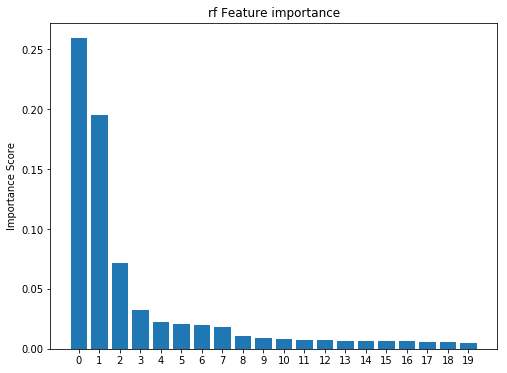

In [9]:
rf_res = pd.DataFrame(feat_sel(data, 'listingsHouseholdsRatio'))

Select the first 11 features, at that point the feature importance flatlines.

In [10]:
rf_feats = list(rf_res[1][:11])

In [11]:
rf_feats

['Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959',
 'Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled']

### LASSO Feature Selection

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)


lasso Feature ranking:        0                                                  1
0  0.515  Percent; RELATIONSHIP - Population in househol...
1  0.315  Percent; UNITS IN STRUCTURE - Total housing un...
2  0.280  Percent; MARITAL STATUS - Females 15 years and...
3  0.260  Percent; UNITS IN STRUCTURE - Total housing un...
4  0.250  Percent; MARITAL STATUS - Males 15 years and o...


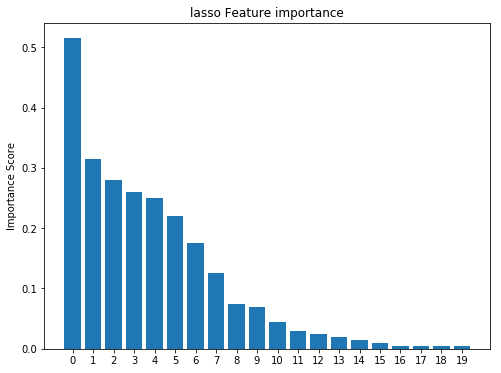

In [12]:
#with fit intercept set to true and normalize set to true
lasso_res = pd.DataFrame(feat_sel(data, 'listingsHouseholdsRatio', model='lasso',alpha=.0001))

Select the first 14 features.

In [13]:
las_feats = list(lasso_res[1][:14])

In [14]:
las_feats

['Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families)',
 'Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Nonfamily households',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Information',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - With own children of the householder under 18 years',
 'Percent; RELATIONSHIP - Population in househo

### Compare the features selected by LASSO and Random Forest

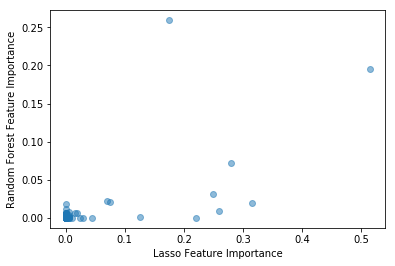

In [15]:
feats = pd.merge(lasso_res, rf_res, on=1, suffixes=('_lasso', '_rf'))
pl.plot(feats['0_lasso'], feats['0_rf'], 'o', alpha=.5)
pl.xlabel('Lasso Feature Importance')
pl.ylabel('Random Forest Feature Importance')

### Constructing Models

In [16]:
#split data into training and test sets
train, test = train_test_split(data, test_size=0.3, random_state=0)

In [18]:
output = 'listingsHouseholdsRatio'
y_train = train[output]
y_test = test[output]

** * OLS Model - RF features * **

Linear Model on Random Forest Selected Features 

In Sample RSquared:  0.711967404507
Out of sample R-Squared:  0.586161531493
Out of sample Adjusted R-Squared:  0.472355952653
Model Eval (Median Absolute Error):  0.00104900309259


(0.47235595265315683, 0.0010490030925874346)

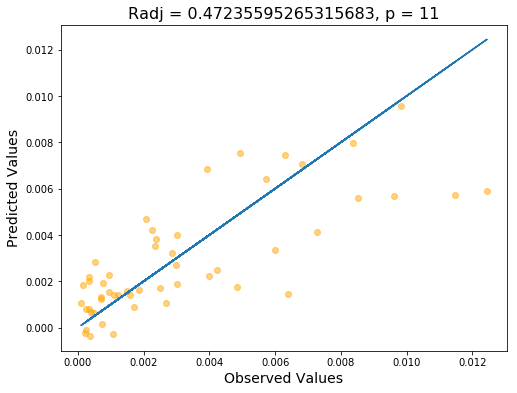

In [19]:
lm_rf = LinearRegression()
lm_rf.fit(train[rf_feats],y_train)
print ('Linear Model on Random Forest Selected Features', '\n')
mdl_eval(lm_rf, output, rf_feats, test, train, 'orange')

In [20]:
print ('Regressors ({}): '.format(len(rf_feats)))
rf_feats

Regressors (11): 


['Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; YEAR STRUCTURE BUILT - Total housing units - Built 1950 to 1959',
 'Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- drove alone',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; COMMUTING TO WORK - Workers 16 years and over - Car, truck, or van -- carpooled']

** * OLS - LASSO Features * **

Linear Model on Lasso Selected Features 

In Sample RSquared:  0.760986224929
Out of sample R-Squared:  0.560448538288
Out of sample Adjusted R-Squared:  0.394131768991
Model Eval (Median Absolute Error):  0.00115951194734


(0.39413176899107116, 0.0011595119473362949)

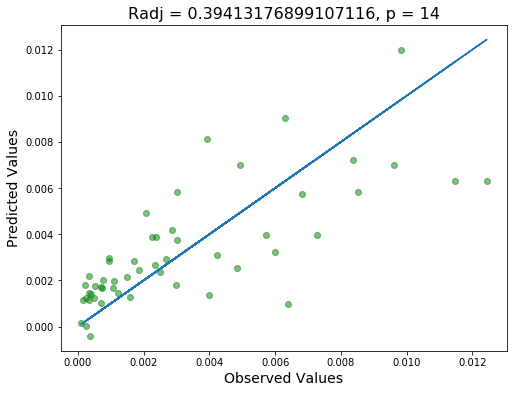

In [21]:
lm_l = LinearRegression()
lm_l.fit(train[las_feats],y_train)
print ('Linear Model on Lasso Selected Features', '\n')
mdl_eval(lm_l, output, las_feats, test, train, 'green')

In [22]:
print ('Regressors ({}): '.format(len(las_feats)))
las_feats

Regressors (14): 


['Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families)',
 'Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Nonfamily households',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; INDUSTRY - Civilian employed population 16 years and over - Information',
 'Percent; HOUSEHOLDS BY TYPE - Total households - Family households (families) - With own children of the householder under 18 years',
 'Percent; RELATIONSHIP - Population in househo

** * OLS on shared features between LASSO and Random Forest * **

In [23]:
shared_feats = list(set(rf_feats) & set(las_feats))

In [24]:
shared_feats

['Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married']

Linear Model on Shared Features 

In Sample RSquared:  0.694976142826
Out of sample R-Squared:  0.587806874206
Out of sample Adjusted R-Squared:  0.511119781036
Model Eval (Median Absolute Error):  0.000884804649023


(0.51111978103552502, 0.00088480464902309839)

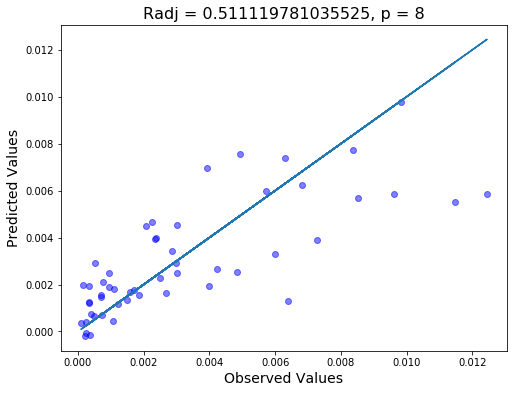

In [25]:
lm_sh = LinearRegression()
lm_sh.fit(train[shared_feats],y_train)
print ('Linear Model on Shared Features', '\n')
mdl_eval(lm_sh, output, shared_feats, test, train, 'blue')

In [26]:
print ('Regressors ({}): '.format(len(shared_feats)))
shared_feats

Regressors (8): 


['Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; UNITS IN STRUCTURE - Total housing units - 10 to 19 units',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married']

** * Removing weak features from RF * **

1
Linear Model on Random Forest Selected Features 

In Sample RSquared:  0.71194856281
Out of sample R-Squared:  0.586440504197
Out of sample Adjusted R-Squared:  0.485572334489
Model Eval (Median Absolute Error):  0.0010422530981
2
Linear Model on Random Forest Selected Features 

In Sample RSquared:  0.686651452744
Out of sample R-Squared:  0.604167250519
Out of sample Adjusted R-Squared:  0.519345947059
Model Eval (Median Absolute Error):  0.00101977108689
3
Linear Model on Random Forest Selected Features 

In Sample RSquared:  0.681185268757
Out of sample R-Squared:  0.599848146735
Out of sample Adjusted R-Squared:  0.525401290314
Model Eval (Median Absolute Error):  0.00109771450678
4
Linear Model on Random Forest Selected Features 

In Sample RSquared:  0.681102101792
Out of sample R-Squared:  0.599924813197
Out of sample Adjusted R-Squared:  0.536276488024
Model Eval (Median Absolute Error):  0.00111050851974
5
Linear Model on Random Forest Selected Features 

In Sample RSquared

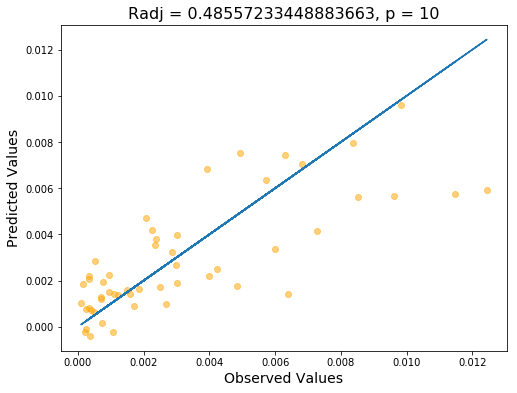

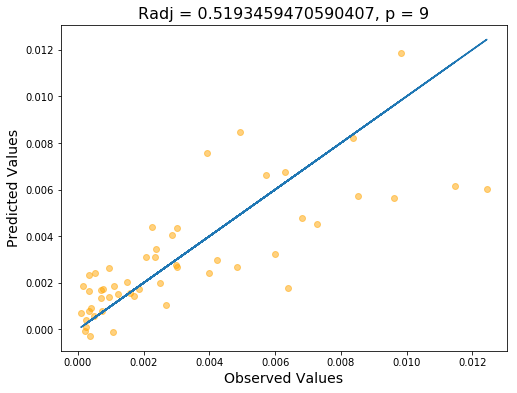

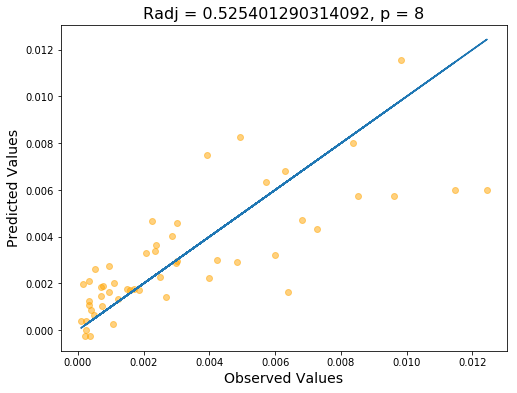

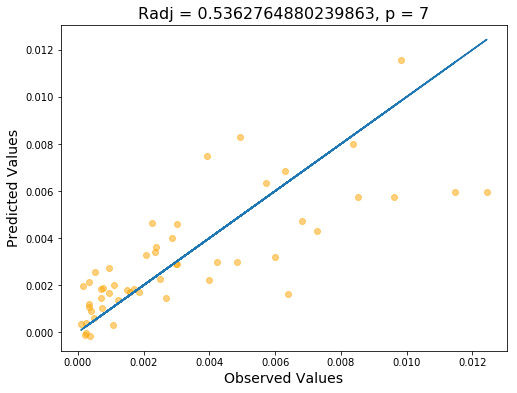

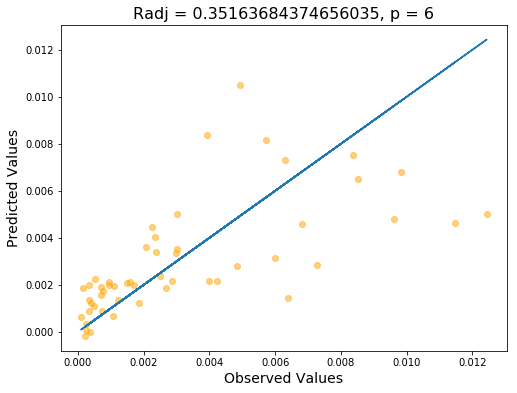

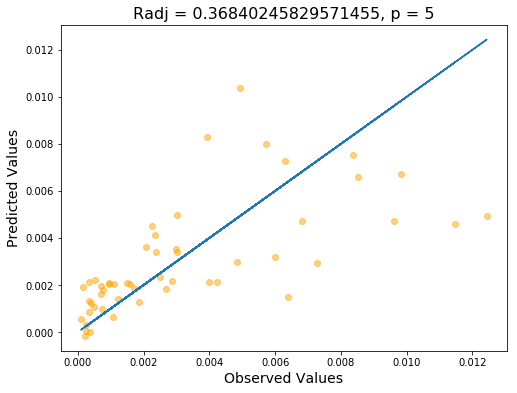

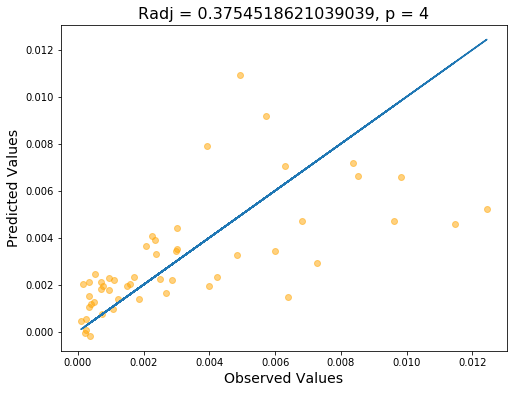

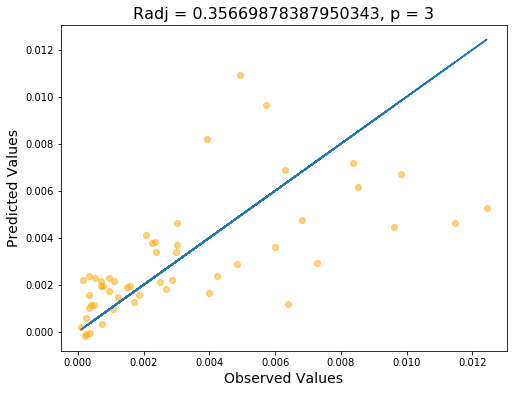

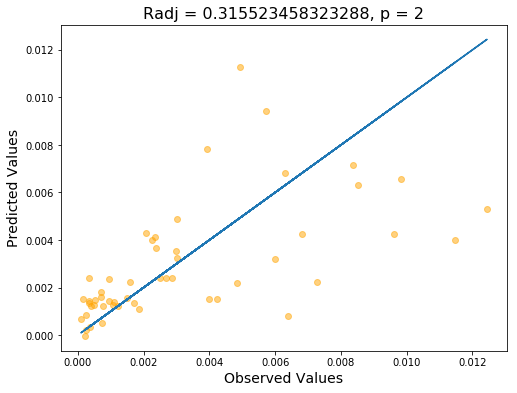

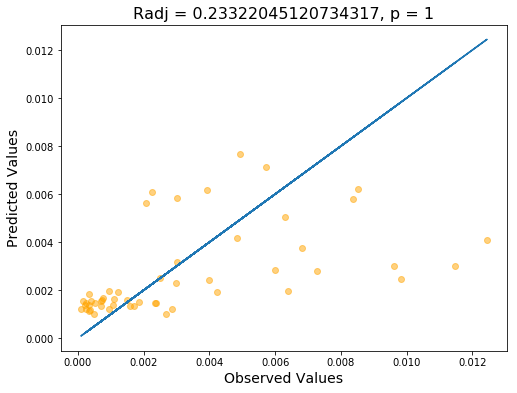

In [27]:
lm_rf = LinearRegression()
for i in np.arange(1, len(rf_feats)):
    print (i)
    lm_rf.fit(train[rf_feats[:-i]],y_train)
    print ('Linear Model on Random Forest Selected Features', '\n')
    mdl_eval(lm_rf, output, rf_feats[:-i], test, train, 'orange')

In [29]:
rf_feats[:7]

['Percent; PLACE OF BIRTH - Total population - Native - Born in United States - Different state',
 'Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married',
 'Percent; MARITAL STATUS - Males 15 years and over - Never married',
 'Percent; SEX AND AGE - 25 to 34 years',
 'Percent; MARITAL STATUS - Males 15 years and over - Now married, except separated',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units']

** * Removing weak features from LASSO * **

1
Linear Model on LASSO Selected Features 

In Sample RSquared:  0.742005284136
Out of sample R-Squared:  0.596783010326
Out of sample Adjusted R-Squared:  0.458840355964
Model Eval (Median Absolute Error):  0.00109400929859
2
Linear Model on LASSO Selected Features 

In Sample RSquared:  0.730555152438
Out of sample R-Squared:  0.565381376254
Out of sample Adjusted R-Squared:  0.431652568948
Model Eval (Median Absolute Error):  0.00112302204751
3
Linear Model on LASSO Selected Features 

In Sample RSquared:  0.708313989501
Out of sample R-Squared:  0.57113463905
Out of sample Adjusted R-Squared:  0.453196664789
Model Eval (Median Absolute Error):  0.00104619887995
4
Linear Model on LASSO Selected Features 

In Sample RSquared:  0.706592565932
Out of sample R-Squared:  0.573726951335
Out of sample Adjusted R-Squared:  0.469757915076
Model Eval (Median Absolute Error):  0.00103821508205
5
Linear Model on LASSO Selected Features 

In Sample RSquared:  0.694057034965
Out of sample R-Squar

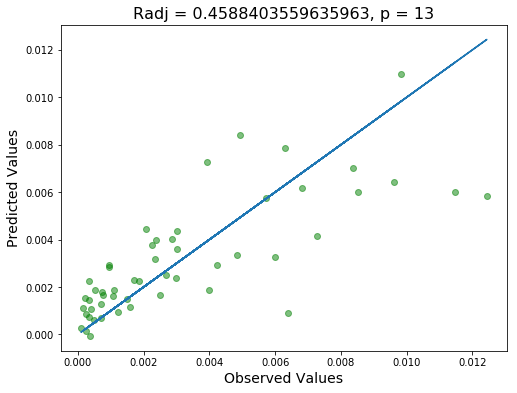

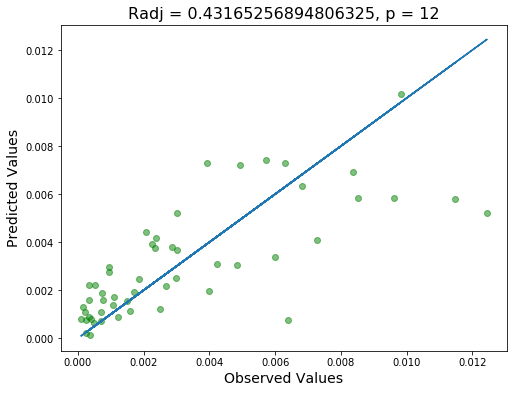

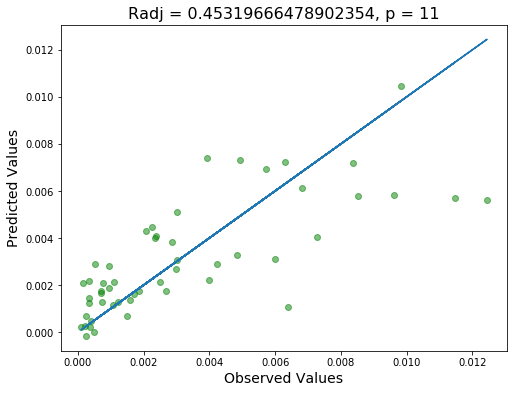

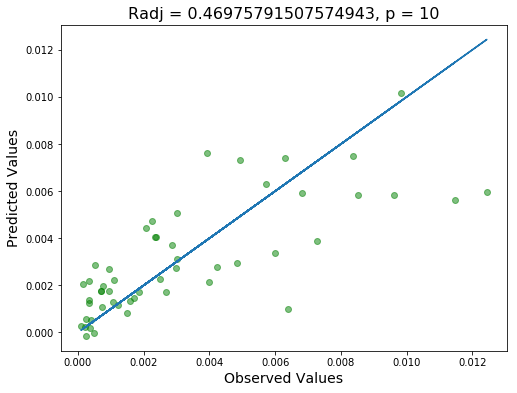

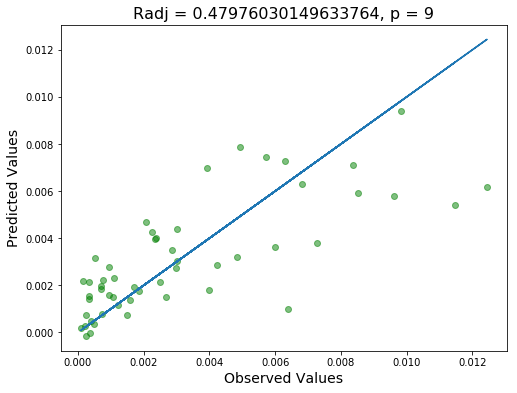

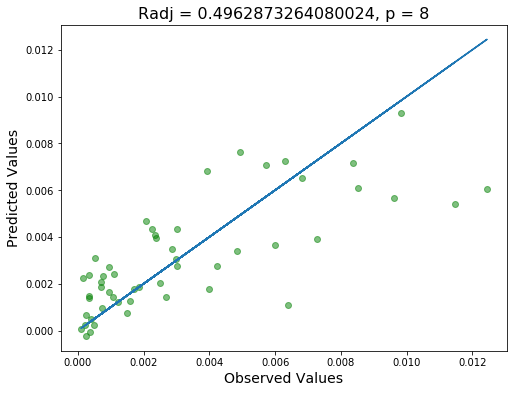

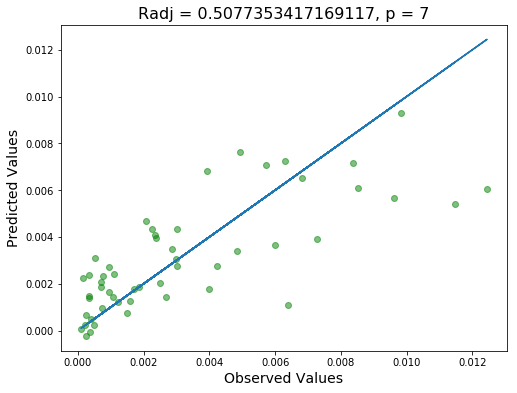

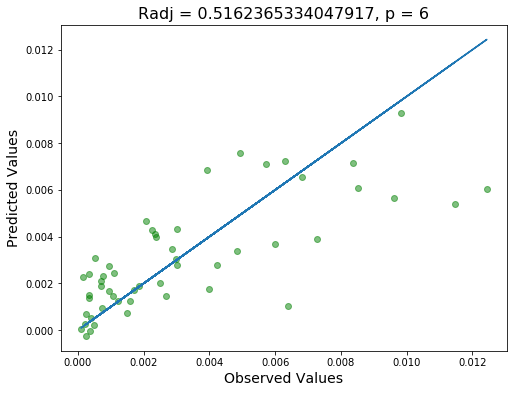

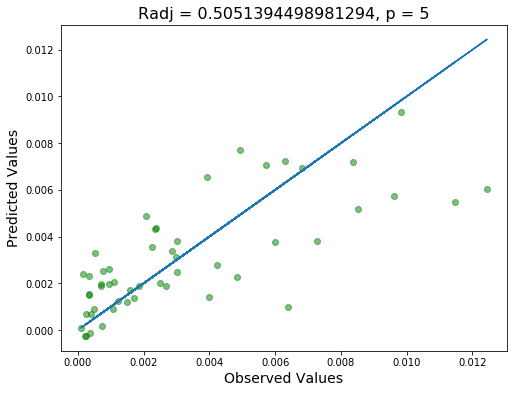

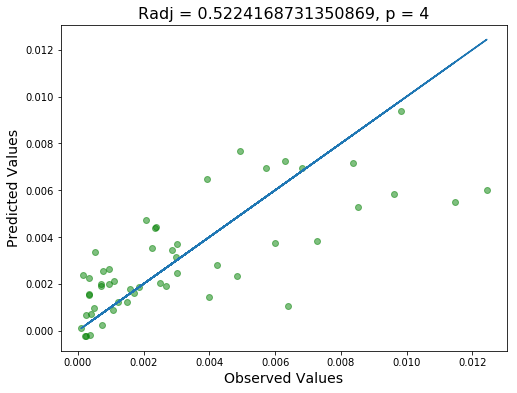

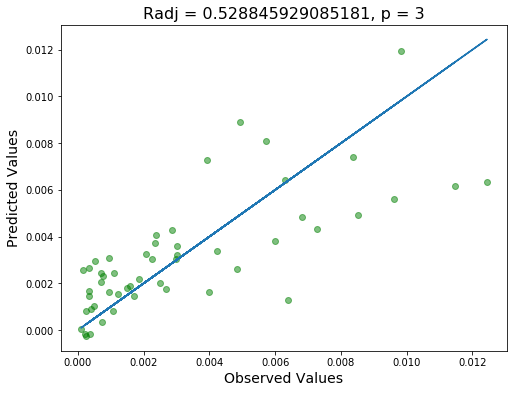

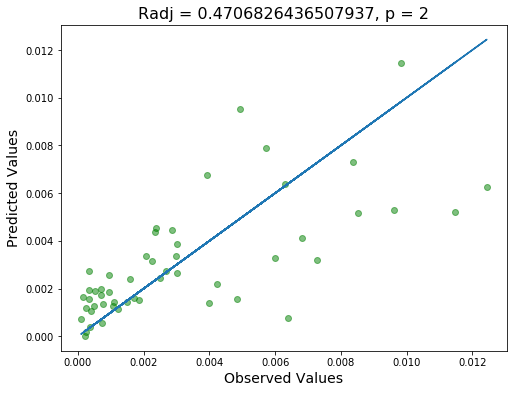

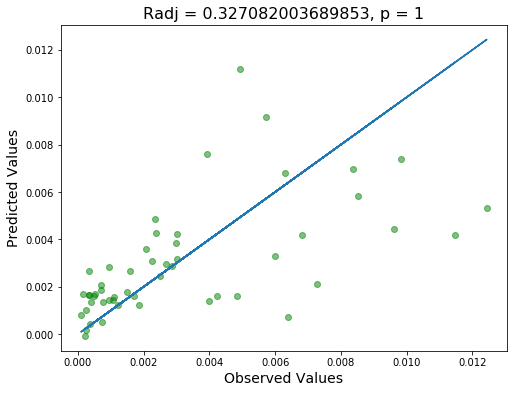

In [32]:
lm_las = LinearRegression()
for i in np.arange(1, len(las_feats)):
    print (i)
    lm_las.fit(train[las_feats[:-i]],y_train)
    print ('Linear Model on LASSO Selected Features', '\n')
    mdl_eval(lm_las, output, las_feats[:-i], test, train, 'green')

In [33]:
las_feats[:3]

['Percent; RELATIONSHIP - Population in households - Nonrelatives',
 'Percent; UNITS IN STRUCTURE - Total housing units - 5 to 9 units',
 'Percent; MARITAL STATUS - Females 15 years and over - Never married']